# Libraries

In [15]:
import numpy as np
import numpy.random as rnd
import numpy.linalg
import matplotlib.pyplot as plt
from numpy import linalg as LA
from numpy.random import normal
import scipy
from scipy.spatial.transform import Rotation as R

In [16]:


class Configuration:
    #"""generate a configuration of spins"""
    
    def __init__(self, a,theta,Nx,Ny, J,T):
        #'we create a kagome lattice from parameter a and theta with Nx*Ny*3 spins , '
        self.a,self.theta,self.Nx,self.Ny,self.J,self.T=a,theta,Nx,Ny,J,T
        self.N=Nx*Ny

        # a_1 and a_2 are the lattice translation generating vectors 
        a_1=a*np.array([1,0])
        a_2=a*np.array([-1*np.cos(theta),np.sin(theta)])
        
        # we construct the unit cell
        unit_cell=np.array([[0,0],0.5*a_2,0.5*a_1])
        
        # we construct the grid points from the translations of the lattice
        self.x_l,self.y_l=np.meshgrid(range(Nx),range(Ny))
        A_1=np.tensordot(self.y_l,[a_1,a_1,a_1],axes=0)
        A_2=np.tensordot(self.x_l,[a_2,a_2,a_2],axes=0)

        # the lattice points coordinates are created from adding a unit cell at each grid point
        self.lattice=np.tensordot(np.ones((Nx,Ny)),unit_cell,axes=0)+A_1+A_2

        # we create a dim object containing the dimensions of the lattice 
        dim=self.lattice.shape

        # then we create a random spin configuration  self.config as a unit 3d vector on each grid point
        #np.random.seed(50) #seed control for test
        
        config=2*np.random.rand(dim[0],dim[1],dim[2],3)-1*np.ones((dim[0],dim[1],dim[2],3))
        Norm=np.power(LA.norm(config,axis=0),-1)
        self.config=Norm*config
        #print(self.config)



    def get_energy(self,i,j,s):
        """this part implements the sommation over spins nearest spins"""
        
        # spin that we want to calculate the contribution to the energy
        S=np.array(self.config[i,j,s,:])

        # from the kernel lookup list we see the nearest coordinates
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        # we add the nearest spins
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])
        # we compute the dot product and thus this spin contribution to the energy 
        E=(self.J)*np.dot(S,S_nearest)
        return E



    def total_energy(self):
        """ this part implements the summation of energy over the whole lattice"""

        E=0
        # we sum over each grid point 
        for i in range(self.Nx):
            for j in range(self.Ny):
                for s in range(3):
                    #we compute each spin contribution
                    E=E+self.get_energy(i,j,s)
        
        return E/2 # we divide by 2 because ech vertex is summed twice


    def delta_energy(self,i,j,s):
        ''' this function is used to compute the energy difference for a flip '''
 
        # we compute the sum of the nearest neighbors of the spin that could be flipped
        kernel=np.mod([[[i,j-1,1],[i-1,j,2]],[[i-1,j+1,2],[i,j+1,0]],[[i+1,j-1,1],[i+1,j,0]]],[self.Nx,self.Ny,3])
        S_nearest=np.array(self.config[i,j,(s+1)%3,:]+self.config[i,j,(s+2)%3,:])
        S_nearest+=np.array(self.config[kernel[s,0,0],kernel[s,0,1],kernel[s,0,2],:]+self.config[kernel[s,1,0],kernel[s,1,1],kernel[s,1,2],:])


        #we compute the difference in energy contribution between the flipped and unaltered spin
        Delta_E=(self.J)*np.dot(self.flipped_spin-self.config[i,j,s,:],S_nearest)

        
        return Delta_E




    def Monte_Carlo(self,Nf,overrelaxation=False,ecart_type=0.01):
        '''In this part we implement the Nf monte carlo steps
        here with the metropolis move'''


        # this code will select a number Nf of random 3d rotations 
        #all with the same probability over the sphere
        beta=1/self.T
        q = normal(size=(Nf,4))
        q /= np.linalg.norm(q) 
        r = R.from_quat(q)

        # if we want to use the overrelaxation 
        #this code will select a number Nf of random 3d rotations 
        #with a gaussian distribution around identity
        if overrelaxation==True:
            q =normal(scale=[ecart_type,1],size=(Nf,4))
            #q = normal(size=(Nf,4))
            q /= np.linalg.norm(q) 
            r = R.from_quat(q,scalar_first=True)

        # we select the number Nf of sites that could be flipped
        flips=np.random.randint([0,0,0],[self.Nx-1,self.Ny-1,2],size=(Nf,3))
        random_uniform_distrib=np.random.uniform(0,1,Nf)
        # we initialize a copy of the current spin configuration named self.newconf
        #self.newconf=self.config
        
        #this flag is an integer to count the number of flips that are validated 
        # to keep track of the rejection  rate
        flag=0

        for num,pick in enumerate(flips):
            # we  we rotate a spin of the new configuration 

            self.flipped_spin= r[num].apply( self.config[pick[0],pick[1],pick[2],:] ) 

            # we renormalise this spin after rotation because matrix 
            # multiplication errors can denormalise a little bit after a rotation our unit vectors
            Norm=LA.norm(self.flipped_spin)
            self.flipped_spin/=Norm

            # energy difference calculations
            delta= self.delta_energy(pick[0],pick[1],pick[2])

            #metropolis move
            if random_uniform_distrib[num] <= np.exp(-beta*delta):
            
                self.config[pick[0],pick[1],pick[2],:]=self.flipped_spin
                flag+=1
        print(flag/Nf)


    def display_config(self):

        ax = plt.figure().add_subplot(projection='3d')
        ax.set_ylim(-self.a,self.a*self.Ny)
        ax.set_xlim(-self.a,self.a*(self.Nx+2))
        ax.set_zlim(-1,1)

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')

        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]
        
        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')

        ax.view_init(elev=0, azim=0, roll=0)
        
        plt.show()
        #ax = plt.figure().add_subplot(projection='3d')

        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=90, roll=0)


        plt.show()

        ax2 = plt.figure().add_subplot(projection='3d')
        ax2.set_ylim(-self.a,self.a*(self.Ny))
        ax2.set_xlim(-self.a,self.a*(self.Nx+2))
        ax2.set_zlim(-1,1)
        

        ax2.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        
        ax2.view_init(elev=90, azim=90, roll=0)


        plt.show()

    def spin_realign(self):

        ax = plt.figure().add_subplot(projection='3d')

        ax.set_ylim(-self.a,self.a*self.Ny)
        ax.set_xlim(-self.a,self.a*(self.Nx+2))
        ax.set_zlim(-1,1)

        position=np.reshape(self.lattice,(3*self.Nx*self.Ny,2),order='C')
        arrows=np.reshape(self.config,(3*self.Nx*self.Ny,3),order='C')



        Avg=np.mean(arrows,axis=0)
        print(Avg)
        Avg/=np.linalg.norm(Avg)
        angle=np.sqrt(Avg[0]**2+Avg[1]**2)
        r = R.from_quat([angle,-Avg[1],Avg[0],0])
        arrows=r.apply(arrows,inverse=False)
        print(np.mean(arrows,axis=0))



        # Make the grid
        x, y, z = position[:,0],position[:,1],np.zeros((3*self.Nx*self.Ny))

        # Make the direction data for the arrows
        u = arrows[:,0]
        v = arrows[:,1]
        w = arrows[:,2]

        
        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=0, roll=0)
        plt.show()

        #ax = plt.figure().add_subplot(projection='3d')

        ax.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        ax.view_init(elev=0, azim=90, roll=0)


        plt.show()

        ax2 = plt.figure().add_subplot(projection='3d')
        ax2.set_ylim(-self.a,self.a*(self.Ny))
        ax2.set_xlim(-self.a,self.a*(self.Nx+2))
        ax2.set_zlim(-1,1)
        

        ax2.quiver(x,y,z, u, v, w, length=1, normalize=False,pivot='tail')
        
        ax2.view_init(elev=90, azim=90, roll=0)


        plt.show()
    def verify_norm(self):
        """ we have sometimes a problem with the  spin vectors not 
        being normalised after too many rotations due to errors so we normalise them after each 
        flip and we verify their maximum norms"""
        print('norm=',LA.norm(self.config,axis=0).max())


    def saveconfig(self,title):
        np.save(title, self.config)



In [ ]:
J=1
kb=1.38*10**-23
T=0.001
Nx=50
Ny=50
theta=2*np.pi/3
a=1
A=Configuration(1,theta,Nx,Ny,J,T)

B=Configuration(1,theta,Nx,Ny,J,T)
#C=Configuration(1,theta,Nx,Ny,J,T)
N=Nx*Ny*3
#E_0=(J/2)*Nx*Ny*3*1
print((A.total_energy())/N)
print((B.total_energy())/N)
#print((C.total_energy())/N)
TestA=[]
TestB=[]

for u in range(50):
    A.Monte_Carlo(10000,overrelaxation=False)
    #A.Overrelaxation(200)
    #A.verify_norm()
    TestA.append((A.total_energy())/N)


for u in range(50):
    #A.Monte_Carlo(200)
    B.Monte_Carlo(10000,overrelaxation=True, ecart_type=10**-1)
    #B.verify_norm()
    TestB.append((B.total_energy())/N)




import matplotlib.pyplot as plt

plt.plot(range(len(TestA)),TestA,label='monte')
plt.plot(range(len(TestB)),TestB,label='monte carlo small movement')

plt.legend()
plt.show()

0.0006688844653868273
-0.0005613283214791747


/tmp/ipykernel_9201/2177762932.py:131: RuntimeWarning: overflow encountered in exp
  if random_uniform_distrib[num] <= np.exp(-beta*delta):


0.3809
0.2227
0.1593
0.1109
0.0793
0.0685


# Infos about the simulation class

- we generate the kagome lattice site coordinate from a lieb lattice that we sheared  with an angle of 2*pi/3 see
https://doi.org/10.48550/arXiv.2506.15023

- for spin rotations we need to pick a random 3d rotations we thus use a normal distribution of quaternions see method
https://imois.in/posts/random-vectors-and-rotations-in-3d/
https://doi.org/10.1016/B978-0-08-050755-2.50036-1

The 3 first indices of the matrix are for each spins  the first Nx triangles horizontally Ny triangles
vertically and 3 sites in the triangle the left one is 0 the top one is 1 an the left one is 2



- I need to rewrite a fast energy calculation to implement the different monte carlo algorythm 
- we also need a fast way to display the lattice

75


/tmp/ipykernel_9201/4024018043.py:131: RuntimeWarning: overflow encountered in exp
  if random_uniform_distrib[num] <= np.exp(-beta*delta):


0.0184
0.0046
0.0015
0.0011
0.0015
0.0009
0.0008
0.0011
0.0009
0.0003
0.0005
0.0005
0.0006
0.0004
0.0004
0.0003
0.0003
0.0004
0.0002
0.0
0.0001
0.0003
0.0002
0.0004
0.0001
0.0002
0.0
0.0
0.0
0.0003
0.0001
0.0002
0.0001
0.0
0.0002
0.0
0.0
0.0001
0.0
0.0001
0.0001
0.0
0.0002
0.0003
0.0001
0.0002
0.0
0.0002
0.0001
0.0001
0.0002
0.0
0.0002
0.0003
0.0004
0.0001
0.0002
0.0002
0.0003
0.0001
0.0002
0.0003
0.0002
0.0002
0.0001
0.0001
0.0002
0.0001
0.0
0.0
0.0001
0.0
0.0004
0.0001
0.0001
0.0
0.0001
0.0002
0.0003
0.0001
0.0
0.0002
0.0001
0.0001
0.0001
0.0
0.0
0.0003
0.0
0.0
0.0002
0.0002
0.0
0.0
0.0002
0.0001
0.0
0.0001
0.0001
0.0001


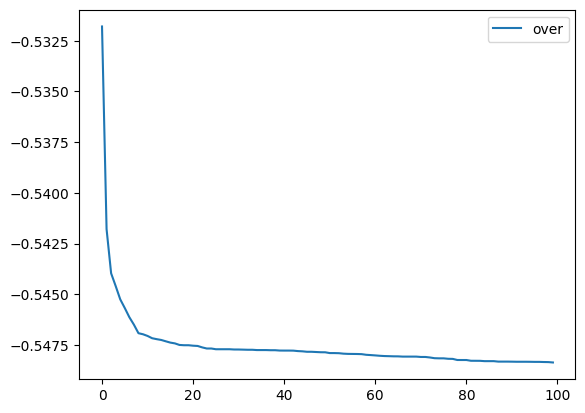

75
0.0154
0.0013
0.0018
0.0011
0.001
0.0011
0.0008
0.0016
0.0006
0.0006
0.0003
0.001
0.0008
0.001
0.0003
0.0007
0.0005
0.0004
0.0005
0.0005
0.0007
0.0004
0.0
0.0005
0.0001
0.0003
0.0002
0.0001
0.0001
0.0005
0.0002
0.0001
0.0005
0.0003
0.0005
0.0004
0.0003
0.0001
0.0005
0.0002
0.0002
0.0003
0.0007
0.0005
0.0006
0.0006
0.001
0.0003
0.0002
0.0009
0.0003
0.0003
0.0002
0.0002
0.0004
0.0002
0.0005
0.0005
0.0001
0.0002
0.0
0.0
0.0003
0.0003
0.0001
0.0004
0.0004
0.0003
0.0005
0.0005
0.0001
0.0001
0.0003
0.0003
0.0003
0.0001
0.0001
0.0002
0.0002
0.0002
0.0001
0.0003
0.0002
0.0005
0.0004
0.0005
0.0002
0.0
0.0001
0.0001
0.0007
0.0005
0.0001
0.0002
0.0002
0.0002
0.0002
0.0004
0.0002
0.0


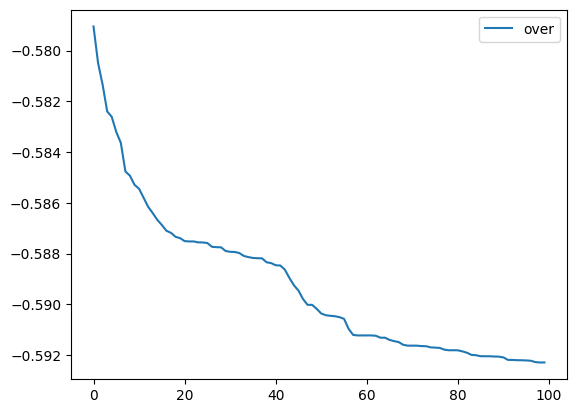

75
0.0185
0.0049
0.003
0.0017
0.0021
0.0016
0.001
0.0013
0.0006
0.0005
0.0007
0.0007
0.0006
0.0006
0.0005
0.0005
0.0005
0.0005
0.0005
0.0006
0.0003
0.0006
0.0007
0.0007
0.0006
0.0006
0.001
0.0007
0.0008
0.0007
0.0011
0.0004
0.0005
0.0005
0.0002
0.0002
0.0009
0.0007
0.0004
0.0004
0.0006
0.0006
0.0006
0.0003
0.0006
0.0004
0.0006
0.0007
0.0005
0.0003
0.0004
0.0005
0.0004
0.0007
0.0004
0.0005
0.001
0.0007
0.0001
0.0003
0.0006
0.0008
0.0003
0.0007
0.0004
0.0007
0.001
0.0003
0.001
0.0005
0.0003
0.0004
0.0005
0.0009
0.0006
0.0006
0.0004
0.0004
0.001
0.0005
0.0006
0.0005
0.0006
0.0004
0.0007
0.0005
0.0002
0.0004
0.0006
0.0008
0.0002
0.0004
0.0005
0.0005
0.0004
0.0008
0.0002
0.0003
0.001
0.0006


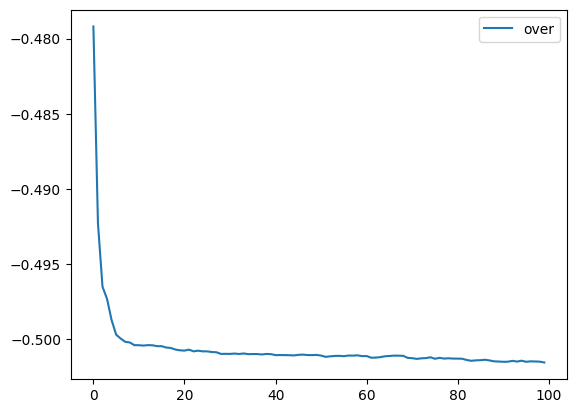

75
0.0213
0.0077
0.0064
0.0069
0.0063
0.006
0.0063
0.0055
0.0038
0.0061
0.0057
0.0053
0.0051
0.0065
0.0034
0.0051
0.0045
0.0058
0.005
0.0049
0.0075
0.0048
0.005
0.0051
0.0064
0.0054
0.005
0.0037
0.0054
0.0086
0.0052
0.0051
0.0058
0.0056
0.0054
0.0067
0.0066
0.0048
0.0058
0.0053
0.0052
0.0059
0.0052
0.0066
0.0063
0.0064
0.0059
0.0064
0.0046
0.0047
0.005
0.0056
0.0059
0.0061
0.004
0.0056
0.0066
0.0042
0.0053
0.0064
0.0062
0.0062
0.0045
0.0054
0.0047
0.0059
0.0049
0.0044
0.0044
0.0056
0.0038
0.0056
0.0061
0.0067
0.0058
0.0046
0.0059
0.0047
0.0047
0.0052
0.0058
0.0052
0.0049
0.0044
0.0052
0.0059
0.0052
0.0043
0.0066
0.0052
0.0047
0.0059
0.0053
0.0067
0.0048
0.0042
0.0063
0.0049
0.0067
0.0054


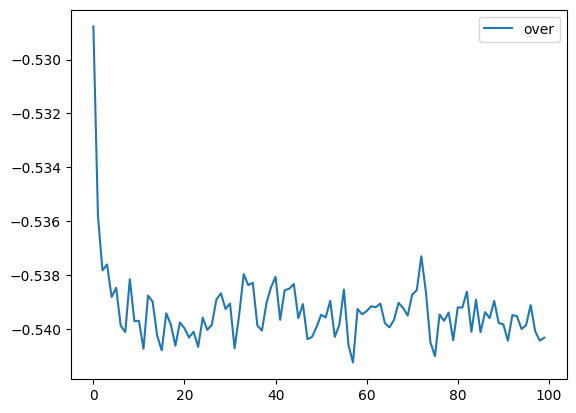

75
0.066
0.0612
0.0623
0.0507
0.0578
0.0561
0.0566
0.0539
0.0546
0.0557
0.0594
0.0581
0.0589
0.0589
0.0502
0.0588
0.0546
0.058
0.0588
0.0569
0.0558
0.0571
0.0579
0.0568
0.0534
0.0524
0.055
0.0517
0.0518
0.0586
0.053
0.0602
0.058
0.0589
0.0597
0.0578
0.0577
0.0538
0.0551
0.0514
0.0554
0.0564
0.0565
0.056
0.0613
0.0575
0.0541
0.0618
0.0585
0.0556
0.0584
0.0564
0.0555
0.0532
0.0561
0.053
0.0571
0.0582
0.0563
0.0557
0.0586
0.0579
0.0556
0.0609
0.0494
0.0586
0.0528
0.0509
0.0555
0.0588
0.0538
0.0622
0.0563
0.0536
0.0546
0.065
0.0592
0.0566
0.0591
0.0514
0.0639
0.058
0.053
0.0531
0.0581
0.0522
0.0536
0.0583
0.0601
0.0553
0.0587
0.0582
0.0557
0.0618
0.0543
0.0576
0.0481
0.0532
0.0551
0.0555


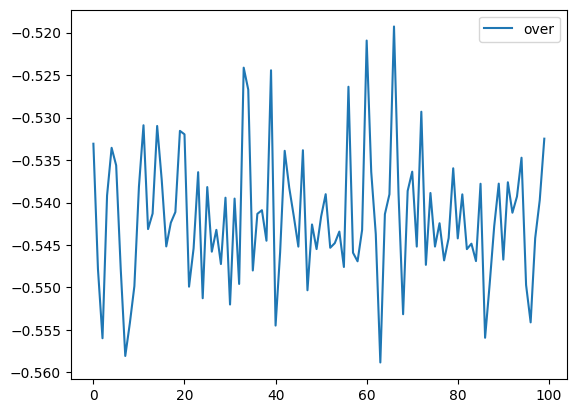

In [ ]:
J=1
kb=1.38*10**-23
T=[10**-5,10**-4,10**-3,10**-2,10**-1]
Nx=5
Ny=5
theta=2*np.pi/3
a=1


N=Nx*Ny*3

for k,Temp in enumerate(T):
    TestA=[]
    print(N)


    A=Configuration(1,theta,Nx,Ny,J,Temp)
    TestA=[]
    for u in range(100):
        
        A.Monte_Carlo(10000,overrelaxation=True, ecart_type=0.001)
        TestA.append((A.total_energy())/N)

        #A.Monte_Carlo(10000000,overrelaxation=False)
    A.total_energy()
    title='smallverconfigtestT'+str(k-5)

    import matplotlib.pyplot as plt

    plt.plot(range(len(TestA)),TestA,label='over')
    plt.legend()
    plt.show()
    A.saveconfig(title)
 
        